# Selectionner les caracteristiques
## Significativité des résultats, nettoyer son corpus, métriques d'évaluation

In [121]:
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load("ro_core_news_sm")

data = pd.read_csv("/Users/madalina/Documents/M1TAL/outils_trait_corpus/constitution-corpus/data/clean/news_combined.csv")


# add a column to calculate the percentage of adjectives in the text
data["adj_percentage"] = data["text"].apply(lambda x: len([token for token in nlp(x) if token.pos_ == "ADJ"]) / len(nlp(x)) * 100)
data["no_tokens"] = data["text"].apply(lambda x: len(nlp(x)))



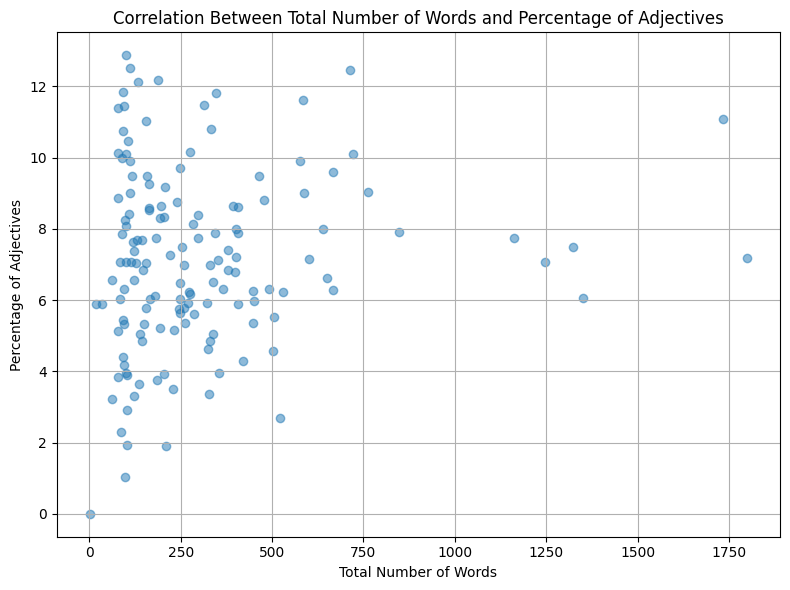

In [122]:
import matplotlib.pyplot as plt

# Extract data
total_number_words = data["no_tokens"].tolist()
adj_percentage = data["adj_percentage"].tolist()

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(total_number_words, adj_percentage, alpha=0.5)

# Add labels and title
plt.xlabel('Total Number of Words')
plt.ylabel('Percentage of Adjectives')
plt.title('Correlation Between Total Number of Words and Percentage of Adjectives')

# Display plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [123]:
correlation = data["no_tokens"].corr(data["adj_percentage"])
print(f"The correlation between the total number of words and the percentage of adjectives is {correlation}")

The correlation between the total number of words and the percentage of adjectives is 0.12926891895385026


In [124]:
from scipy.stats import pearsonr

_, p_value = pearsonr(data["no_tokens"], data["adj_percentage"])
print(f"The p-value is {p_value}")

The p-value is 0.12122776432853481


Le coefficient de corrélation de 0,12926891895385026 indique une faible relation linéaire positive entre le nombre total de mots et le pourcentage d'adjectifs. Cela signifie que lorsque le nombre total de mots dans un article augmente, le pourcentage d'adjectifs tend également à augmenter légèrement, mais la relation n'est pas forte.

La p-value de 0,12122776432853481 est plus grande que 0,05, ce qui signifie qu'on ne peut pas conclure qu'il existe une corrélation statistiquement significative entre le nombre total de mots et le pourcentage d'adjectifs.

Ainsi, bien qu'il existe une légère corrélation positive entre les deux variables, elle n'est pas statistiquement significative, ce qui suggère que la corrélation observée pourrait être due au hasard plutôt qu'à une véritable relation sous-jacente.

Pour voir si ce résultat est correct, il faudrait augmenter le nombre de données et ameliorer la qualité de ces données en les nettoyant (on voit qu'il y a par exemple un texte avec 0 mots).

In [125]:
# eliminate the outliers
def identify_outliers(data):
    # Calculate the IQR of the data
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    return outliers.index

# Identify the outliers
outliers = identify_outliers(data['no_tokens'])

# Identify the rows where there are fewer than 20 tokens in the article (likely to not be an article)
few_tokens = data[data['no_tokens'] <= 20].index

# Combine the indices of the outliers and the rows with few tokens
to_drop = outliers.union(few_tokens)

# Drop the identified rows
data_without_outliers = data.drop(to_drop)

print(data_without_outliers)

# Drop the 'adj_percentage' and 'no_tokens' columns
data_without_outliers = data_without_outliers.drop(columns=['adj_percentage', 'no_tokens'])

# Save the DataFrame containing the clean data to a CSV file
data_without_outliers.to_csv('/Users/madalina/Documents/M1TAL/outils_trait_corpus/constitution-corpus/data/clean/news_combined_without_outliers.csv', index=False)


           id  category                                               text  \
0    22329753         1  Secretarul $NE$ de stat a $NE$ , Janet Yellen ...   
1    22329745         2  Cătălin Cîrstoiu a vorbit , la Antena 3 CNN , ...   
2    22329472         2  „ Vă spun ceva , vom câştiga alegerile . Vom s...   
3    22329360         3  $NE$ $NE$ $NE$ , din cadrul grupului Intrakat ...   
4    22329172         3  $NE$ Europeană a aprobat reintroducerea unei s...   
..        ...       ...                                                ...   
140    745491         1    În acest timp , numărul de trunchiuri îmbrăț...   
141    497838         4    Vă prezentăm în continuare analizele recoman...   
142    745490         1    Echipa de arheologi a examinat mormîntul și ...   
143    473567         4    În $NE$ rind este nevoie să vă calcula norma...   
144    745478         1    $NE$ , transmise de $NE$ Agenţiei Spaţiale E...   

     country  adj_percentage  no_tokens  
0    Romania       10

In [136]:
from nlpaug.augmenter.word import SynonymAug, RandomWordAug

# Define the augmenters
syn_aug = SynonymAug(aug_src='wordnet')
rand_word_aug = RandomWordAug()

romanian_items = data_without_outliers[data_without_outliers.country == 'Romania' ]
moldovan_items = data_without_outliers[data_without_outliers.country == 'Moldova' ]

# Get the maximum count of articles in any category for any country
max_count = max(romanian_items['category'].value_counts().max(), moldovan_items['category'].value_counts().max())

# Create new DataFrames to store the augmented data
augmented_romanian = pd.DataFrame(columns=romanian_items.columns)
augmented_moldovan = pd.DataFrame(columns=moldovan_items.columns)

# For each country
for country_items, augmented_country in [(romanian_items, augmented_romanian), (moldovan_items, augmented_moldovan)]:
    # For each category
    for category in range(6):
        # Get the count of articles in this category
        category_count = len(country_items[country_items.category == category])
        # If there are fewer articles in this category than the maximum count
        if category_count < max_count:
            # Get the rows of articles in this category
            category_rows = country_items[country_items.category == category]
            # Calculate how many new rows we need to create
            num_new_rows = max_count - category_count
            # For each new row
            for _ in range(num_new_rows):
                # Randomly select a row to augment
                row = category_rows.sample(1).iloc[0]
                text = row['text']
                # Apply the augmenters
                new_text = syn_aug.augment(text)
                new_text = rand_word_aug.augment(new_text)
                
                # Create a new row with the augmented text and the same values for the other columns
                new_row = pd.DataFrame(row).transpose()
                new_row['text'] = new_text
                # Append the new row to the augmented_country DataFrame
                augmented_country = pd.concat([augmented_country, new_row])

    # If the current country is Romania
    if country_items is romanian_items:
        # Update the romanian_items DataFrame
        romanian_items = pd.concat([romanian_items, augmented_country])
    else:
        # Update the moldovan_items DataFrame
        moldovan_items = pd.concat([moldovan_items, augmented_country])
        
# Combine the augmented data for Romania and Moldova
augmented_data = pd.concat([romanian_items, moldovan_items])
augmented_data.to_csv('/Users/madalina/Documents/M1TAL/outils_trait_corpus/constitution-corpus/data/clean/news_augmented.csv', index=False)


In [137]:
from sklearn.model_selection import train_test_split

# Create a DataFrame from your data
data = pd.DataFrame({
    'id': augmented_data['id'],
    'category': augmented_data['category'],
    'text': augmented_data['text'],
    'country': augmented_data['country']
})

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Save the DataFrames as CSV files
train_df.to_csv('/Users/madalina/Documents/M1TAL/outils_trait_corpus/constitution-corpus/data/training/train.csv', index=False)
test_df.to_csv('/Users/madalina/Documents/M1TAL/outils_trait_corpus/constitution-corpus/data/training/test.csv', index=False)

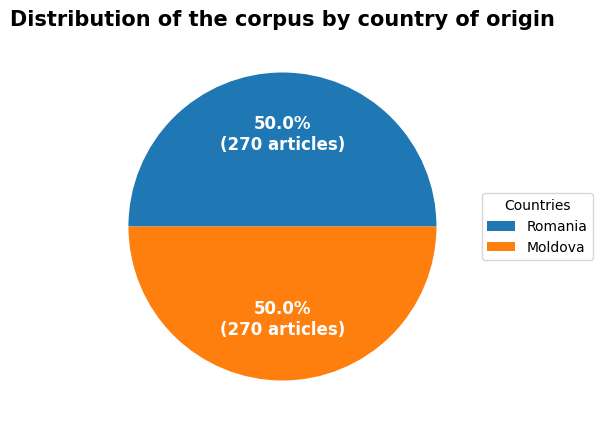

In [138]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

labels = 'Romania', 'Moldova'

sizes = [len(romanian_items), len(moldovan_items)]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} articles)"

wedges, texts, autotexts = ax.pie(sizes, autopct=lambda pct: func(pct, sizes),
                                  textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="Countries",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Distribution of the corpus by country of origin", loc='center', fontsize=15, fontweight='bold')

plt.show()

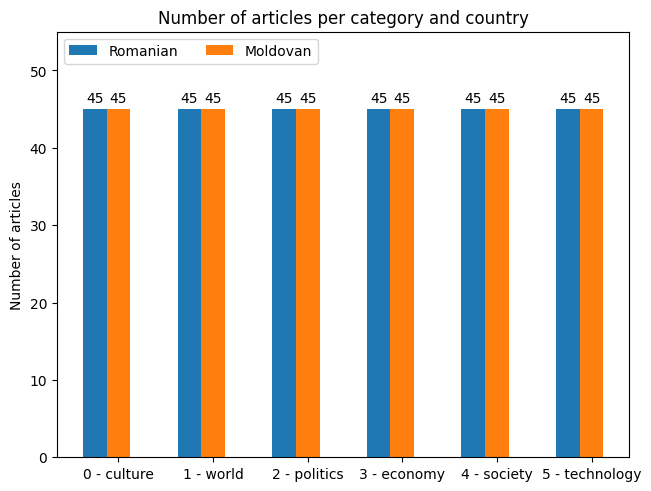

In [139]:

categories = ("0 - culture", "1 - world", "2 - politics", "3 - economy", "4 - society", "5 - technology")


romanian_culture = len(romanian_items[romanian_items.category == 0])
romanian_world = len(romanian_items[romanian_items.category == 1])
romanian_politics = len(romanian_items[romanian_items.category == 2])
romanian_economy = len(romanian_items[romanian_items.category == 3])
romanian_society = len(romanian_items[romanian_items.category == 4])
romanian_technology = len(romanian_items[romanian_items.category == 5])


moldovan_culture = len(moldovan_items[moldovan_items.category == 0])
moldovan_world = len(moldovan_items[moldovan_items.category == 1])
moldovan_politics = len(moldovan_items[moldovan_items.category == 2])
moldovan_economy = len(moldovan_items[moldovan_items.category == 3])
moldovan_society = len(moldovan_items[moldovan_items.category == 4])
moldovan_technology = len(moldovan_items[moldovan_items.category == 5])

distribution = {'Romanian': (romanian_culture, romanian_world,romanian_politics, romanian_economy, romanian_society, romanian_technology), 
                'Moldovan': (moldovan_culture, moldovan_world, moldovan_politics, moldovan_economy, moldovan_society, moldovan_technology)}

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for country, no_articles in distribution.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, no_articles, width, label=country)
    ax.bar_label(rects, padding=3)
    multiplier += 1


ax.set_ylabel('Number of articles')
ax.set_title('Number of articles per category and country')
ax.set_xticks(x + width, categories)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 55)

plt.show()


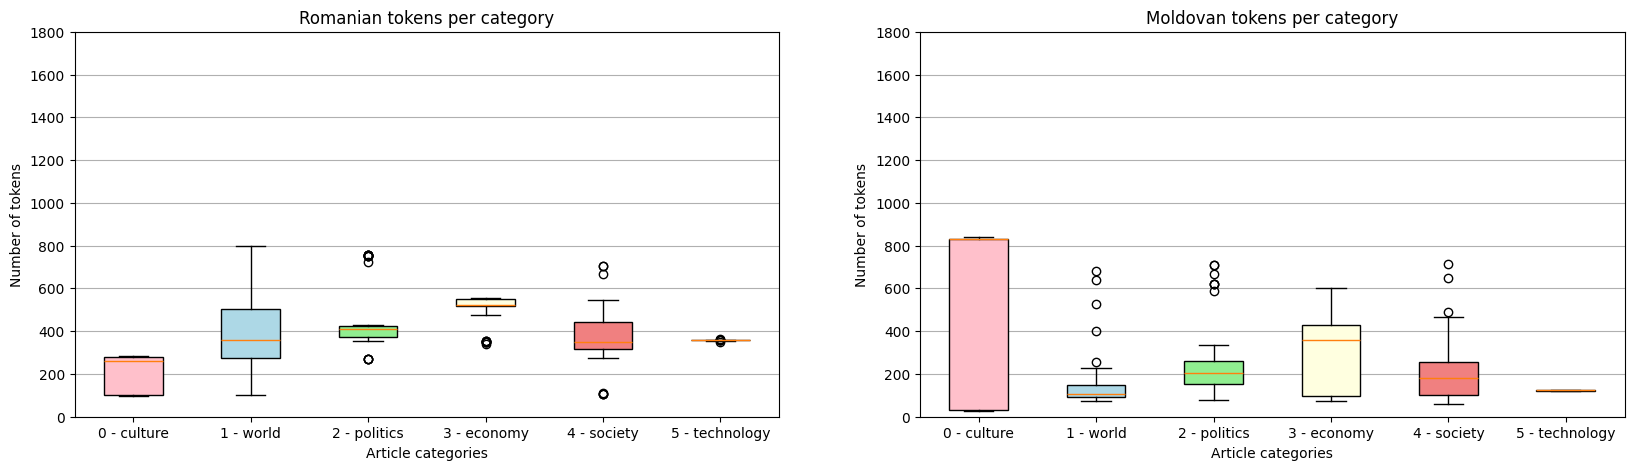

In [141]:
import matplotlib.pyplot as plt
import numpy as np

data["no_tokens"] = data["text"].apply(lambda x: len(nlp(x)))
romanian_items = data[data.country == 'Romania' ]
moldovan_items = data[data.country == 'Moldova' ]

romanian_tokens = romanian_items[["no_tokens", "category"]]
moldovan_tokens = moldovan_items[["no_tokens", "category"]]

# Random test data

romanian_data = [np.array(romanian_tokens[romanian_tokens["category"] == x]["no_tokens"]) for x in range(6)]
moldovan_data = [np.array(moldovan_tokens[moldovan_tokens["category"] == x]["no_tokens"]) for x in range(6)]

labels = ["0 - culture", "1 - world", "2 - politics", "3 - economy", "4 - society", "5 - technology"]

fig, (ax_ro, ax_md) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

bplot_ro = ax_ro.boxplot(romanian_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # used to label x-ticks
ax_ro.set_title('Romanian tokens per category')

# Moldovan tokens per category plot
bplot_md = ax_md.boxplot(moldovan_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # used to label x-ticks
ax_md.set_title('Moldovan tokens per category')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightskyblue']
for bplot in (bplot_ro, bplot_md):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
# make the same scale
ax_ro.set_ylim(0, 1800)
ax_md.set_ylim(0, 1800)
# adding horizontal grid lines
for ax in [ax_ro, ax_md]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Article categories')
    ax.set_ylabel('Number of tokens')

plt.show()